# League of Legends Diamond Elo Win Prediction 

## Introduction
League of legends is "The most" famous and played PC video game of all time as of 2020, The game is a multiplayer 5v5 strategy game that's pretty complex and is hard to understand on the fly, most people spend years of their live playing this video game and this particular dataset is taken from a specific high tier of players where most of them must have played the game for at least an average of 1000 hours.

Players play in a 5v5 fashion trying to mainly destroy their enemy base, each player choosing a champion from a pool of currently over 150 unique champions, the game involves a lot of mechanical and strategic complexity but for the sake of this project the mechanical aspect of specific champions isn't taken into consideration because it rarely affects the final outcome of the game.


### Simple description of the game
Briefly describe the main game strategic behaviours:

---
- Players accumulate gold and experience from a mixture of killing minions, monsters, other players and towers. 
>       More gold -> better items -> easier killing.
      More experience -> higher levels -> easier killing.
- Wards provide map vision so we can see people coming to kill us.
>       More wards -> better vision -> less deaths.
- Main objective of the game is to destroy a number of towers leading to the destruction of the opponents base.
>       Kill towers -> kill base -> win game.

### Dataset description
The dataset provides a dataset of all the prior mentioned factors of game's data of a big amount of diamond ranked games, a very high level of players and the game mode that the players take seriously and play with all they got. 

The dataset provides this data at the 10 minutes mark only, most games stay for more than 20 minutes and for up to 60 minutes so deciding which team is winning by the 10 minutes mark is a rather challenging task even for professional human players, because most of the time the first 10 minutes won't contribute that much towards winning as either teams can flip the game and/or the difference between the two teams won't be that high in the first 10 minutes specially in high level players.

---

The reason I chose this particular dataset is because I'm a semi professional League of Legends player myself and I thought it would be fun to choose a project in a domain that I love and besides that I could use the model to predict the outcome of my own games with a higher accuracy than myself, which is fun and helps me shift the playing style.

The dataset was provided from kaggle and added upon by myself using Riot's API for games' data, still following the rule of data must be on the 10 minutes mark.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os,time,csv
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import svm

### Reading and visualizing the data

In [228]:
dataRead = pd.read_csv('./high_diamond_ranked_10min.csv')
dataRead.head()


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [229]:
cols = dataRead.columns
print(cols)
print("The dataset contains " + str(len(cols)) + " Columns.")

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')
The dataset contains 40 Columns.


The dataset contains lots of columns some of which are redundant, in the next step I choose to get the difference between kills, assists and gold of both teams to visualize the difference and its contribution to the wins instead of the absolute values


In [47]:
dataRead['killsDiff'] = dataRead['blueKills'] - dataRead['blueDeaths']
dataRead['assistsDiff'] = dataRead['blueAssists'] - dataRead['redAssists']
dataRead['goldDiff'] = dataRead['blueTotalGold'] - dataRead['redTotalGold']

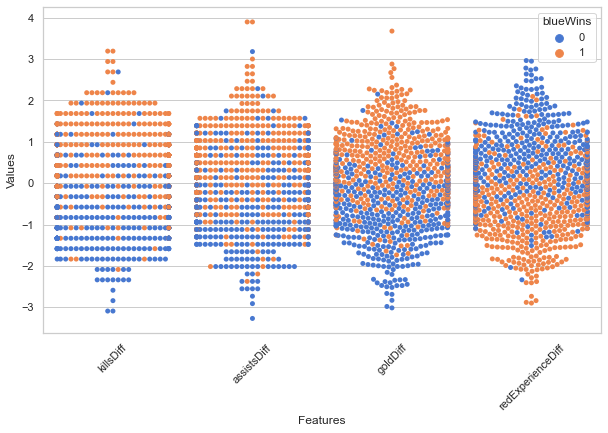

In [55]:
sns.set(style='whitegrid', palette='muted')
data = dataRead[['killsDiff','assistsDiff','goldDiff','redExperienceDiff']].sample(1000)
data_std = (data - data.mean()) / data.std()
data = pd.concat([target_variable, data_std], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')

plt.figure(figsize=(10,6))
sns.swarmplot(x='Features', y='Values', hue='blueWins', data=data)
plt.xticks(rotation=45)
plt.show()

Visualizing the wins according to the differences in kills,assists,gold and experience shows that it's not eas to predict the win when the difference std is less than 2.

The dataset contains some useless columns like the gameId which is used to retrieve more information from the API, in that case we don't need it.

I also separate the target variable(Blue team wins) 


In [4]:
target_variable = dataRead.blueWins
# Drop target and unnecessary features
drop_cols = ['gameId','blueWins']
dataCleaned = dataRead.drop(drop_cols, axis=1)
dataCleaned.head()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,28,2,1,9,6,11,0,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,12,1,0,5,5,5,0,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,15,0,0,7,11,4,1,1,0,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,43,1,0,4,5,5,1,0,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,75,4,0,6,6,6,0,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [7]:
target_variable.value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

The wins per team is is almost equal in this dataset

Now visualizing the correlation of each column value to the rest(including itself), some of these correlations are trivial.

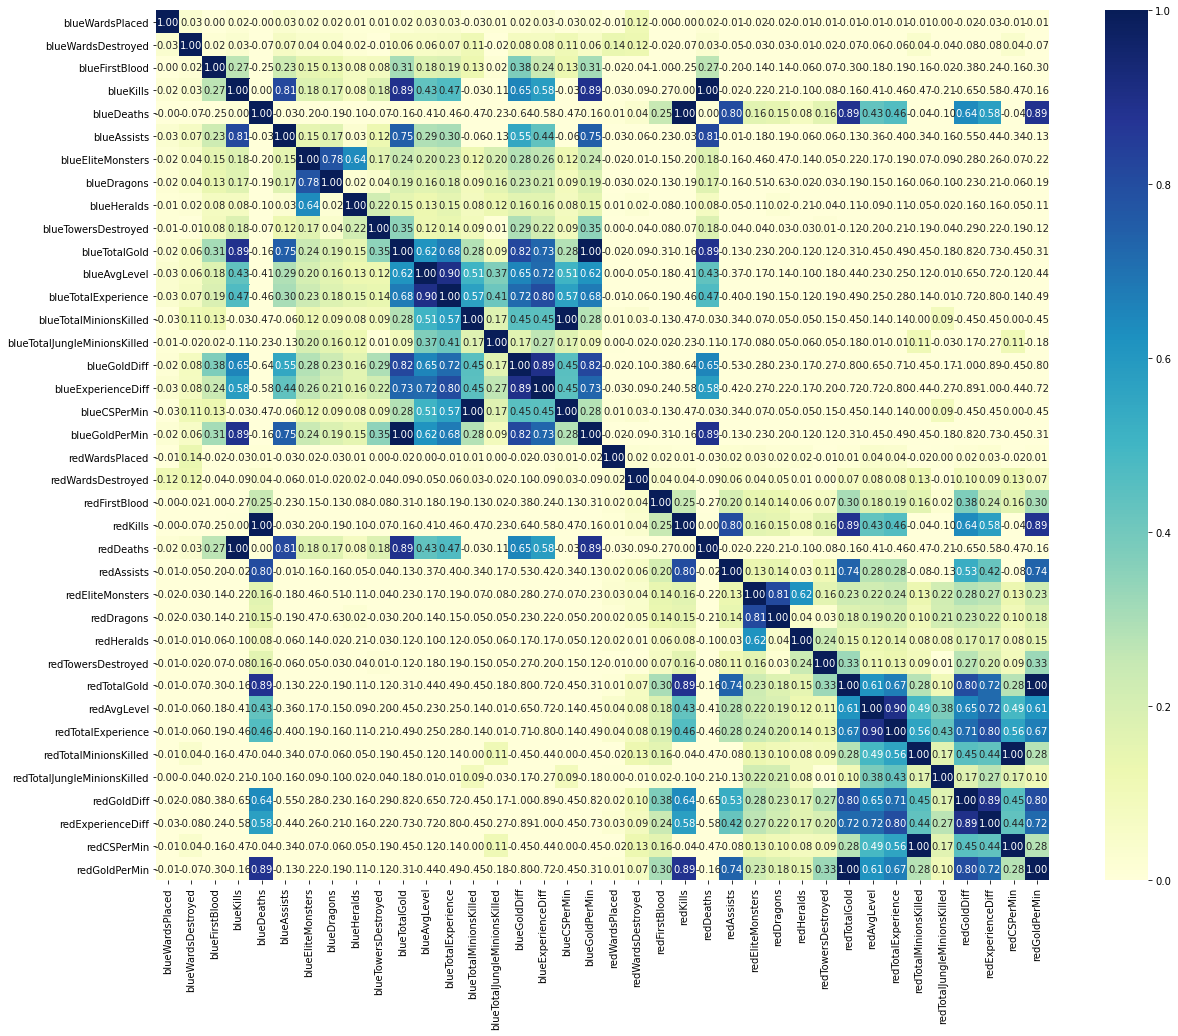

In [19]:
plt.figure(figsize=(20, 16))
data_corr = dataCleaned.corr()
sns.heatmap(data_corr, cmap='YlGnBu', annot=True, fmt='.2f', vmin=0)

In [23]:
data_corr['blueKills'].sort_values(ascending=False)

blueKills                       1.000000
redDeaths                       1.000000
blueGoldPerMin                  0.888751
blueTotalGold                   0.888751
blueAssists                     0.813667
blueGoldDiff                    0.654148
blueExperienceDiff              0.583730
blueTotalExperience             0.472155
blueAvgLevel                    0.434867
blueFirstBlood                  0.269425
blueTowersDestroyed             0.180314
blueEliteMonsters               0.178540
blueDragons                     0.170436
blueHeralds                     0.076195
blueWardsDestroyed              0.033748
blueWardsPlaced                 0.018138
blueDeaths                      0.004044
redKills                        0.004044
redAssists                     -0.020344
blueCSPerMin                   -0.030880
blueTotalMinionsKilled         -0.030880
redWardsPlaced                 -0.034239
redTowersDestroyed             -0.082491
redWardsDestroyed              -0.092278
redHeralds      

For clean visualizing purposes histograms are provided of most data in the dataset that shows the even distribution of most data.

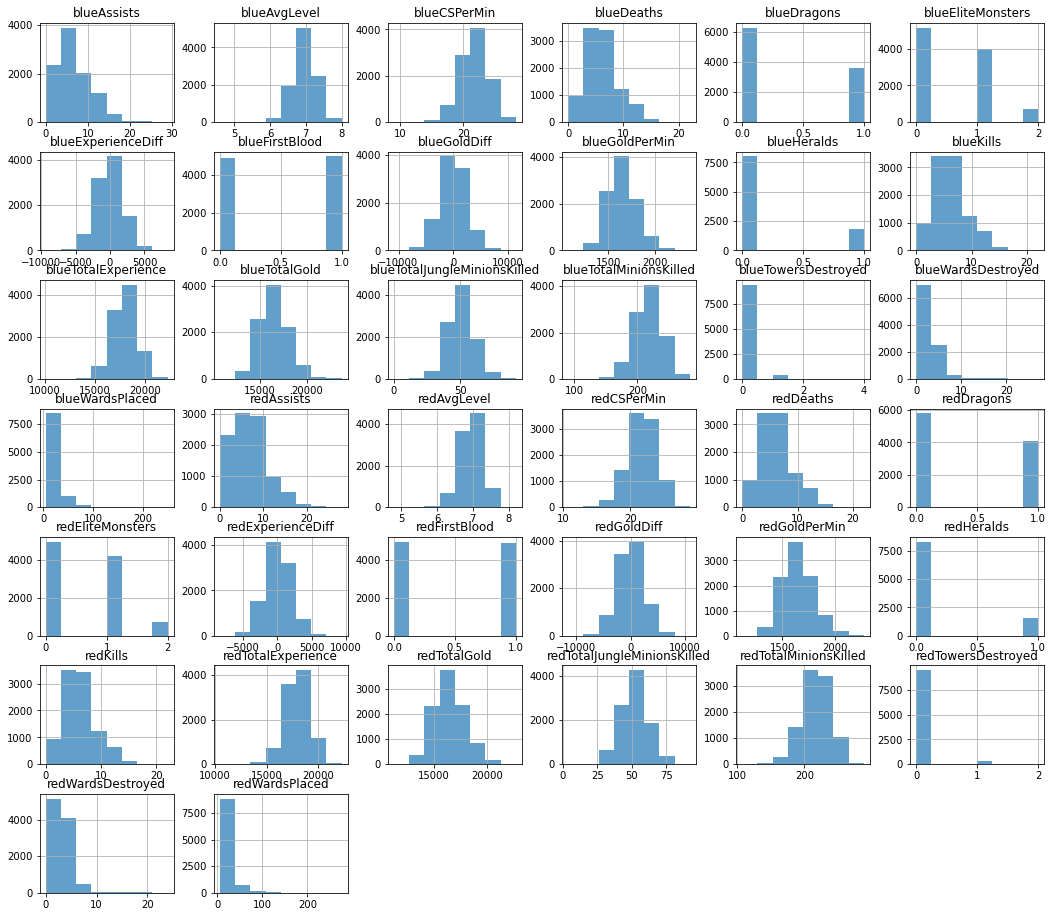

In [17]:
dataCleaned.hist(alpha = 0.7, figsize=(18,16), bins=8);

Getting confusion matrix to calculate the accuracy, recall, precision and f-score of each of the models used later

In [101]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(algorithm, y_pred, y_actual):
    # Create confusion matrix and interpret values
    con = confusion_matrix(target_variable_test, y_pred)
    tp, fn, fp, tn = con[0][0], con[0][1], con[1][0], con[1][1]
    algorithm = algorithm
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f_score = (2 * precision * recall) / (recall + precision)
    return algorithm, accuracy, recall, precision, f_score

I used prettyTable at first to visualize the data easily but then used normal lists and visualized it in a graph after I was done.

In [99]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Algorithm', 'Accuracy', 'Recall', 'Precision', 'F-Score']

In [109]:
l_algorithm = []
l_accuracy = []
l_precision = []
l_recall = []
l_f_score = []

### Splitting data
Since The dataset provided and gathered are in one file, I use sklearn's train test split to split the data by the ration of 80-20% training and testing data.

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()
scaler.fit(dataCleaned)
dataCleaned = scaler.transform(dataCleaned)

data_train, data_test, target_variable_train, target_variable_test = train_test_split(dataCleaned,target_variable, test_size=0.2, random_state=42)

## Naive Bayes 


In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

clf_nb = GaussianNB()
clf_nb.fit(data_train, target_variable_train)

pred_nb = clf_nb.predict(data_test)
acc_nb = accuracy_score(pred_nb, target_variable_test)
print(acc_nb)

0.7236842105263158


Calculating the accuracy parameters of Naive Bayes

In [110]:
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('Naive', pred_nb, target_variable_test)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])
l_algorithm.append(algorithm)
l_accuracy.append(accuracy)
l_precision.append(precision)
l_recall.append(recall)
l_f_score.append(f_score)

## Decision Tree
It took me a while to choose the min samples split values before finding the best values at the grid provided below.

In [49]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

tree = tree.DecisionTreeClassifier()

# search the best params
grid = {'min_samples_split': [1,5, 10, 20, 50, 100,200,300,400,500]},

clf_tree = GridSearchCV(tree, grid, cv=5)
clf_tree.fit(data_train, target_variable_train)

pred_tree = clf_tree.predict(data_test)
acc_tree = accuracy_score(pred_tree, target_variable_test)
print(acc_tree)

0.7201417004048583


Calculating the Desicion tree accuracy parameters.

In [118]:
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('Decision Tree', pred_tree, target_variable_test)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])
l_algorithm.append(algorithm)
l_accuracy.append(round(accuracy,5))
l_precision.append(round(precision,5))
l_recall.append(round(recall,5))
l_f_score.append(round(f_score,5))

## Linear Discriminant Analysis


In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(data_train,target_variable_train)
LinearDiscriminantAnalysis()
pred_lda = clf.predict(data_test)
acc_lda = accuracy_score(pred_lda,target_variable_test)
print(acc_lda)

0.7358299595141701


Noticed that LDA has a higher accuracy than NB and Decision tree

---

Calculating accuracay parameters of LDA

In [112]:
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('Linear Discriminant', pred_lda, target_variable_test)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])
l_algorithm.append(algorithm)
l_accuracy.append(round(accuracy,5))
l_precision.append(round(precision,5))
l_recall.append(round(recall,5))
l_f_score.append(round(f_score,5))

## Perceprton 

I tried to change the valaues of max iterations and removing the early stopping hoping the accuracy can get higher but it didn't get higher than 65.4%

In [62]:
from sklearn.linear_model import Perceptron
clf = Perceptron(early_stopping=False, tol=None, max_iter=5000)
clf.fit(data_train,target_variable_train)
Perceptron()
pred_precep = clf.predict(data_test)
acc_precep = accuracy_score(pred_precep,target_variable_test)
print(acc_precep)

0.6548582995951417


In [119]:
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('Perceptron', pred_precep, target_variable_test)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])
l_algorithm.append(algorithm)
l_accuracy.append(round(accuracy,5))
l_precision.append(round(precision,5))
l_recall.append(round(recall,5))
l_f_score.append(round(f_score,5))

## Support vector machine

Using linear kernel, I tried multiple values of "gamma" and "C" before realizing I could set gamma to auto and scikit will automatically try and use the best gamma value.

In [93]:
from sklearn import svm
clf = svm.SVC(kernel='linear',gamma='auto')
clf.fit(data_train,target_variable_train)
svm.SVC()
pred_svm = clf.predict(data_test)
acc_svm = accuracy_score(pred_svm,target_variable_test)

print(acc_svm)

0.7272267206477733


In [120]:
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('SVM', pred_svm, target_variable_test)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])
l_algorithm.append(algorithm)
l_accuracy.append(round(accuracy,5))
l_precision.append(round(precision,5))
l_recall.append(round(recall,5))
l_f_score.append(round(f_score,5))

## Radial Basis Function
RBF can be used through scikit by using the svm SVC and providing the kernel argument as 'rbf', again gamma is set to automatic for best accuracy.

In [94]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',gamma='auto')
clf.fit(data_train,target_variable_train)
svm.SVC()
pred_rbf = clf.predict(data_test)
acc_rbf = accuracy_score(pred_rbf,target_variable_test)

print(acc_rbf)

0.7302631578947368


In [121]:
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('RBF', pred_rbf, target_variable_test)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])
l_algorithm.append(algorithm)
l_accuracy.append(round(accuracy,5))
l_precision.append(round(precision,5))
l_recall.append(round(recall,5))
l_f_score.append(round(f_score,5))

Printing alll the scores of the used models.

In [108]:
print(table)

+---------------------+----------+---------+-----------+---------+
|      Algorithm      | Accuracy |  Recall | Precision | F-Score |
+---------------------+----------+---------+-----------+---------+
|        Naive        | 0.72368  | 0.72635 |  0.72048  |  0.7234 |
|    Decision Tree    | 0.72014  | 0.74059 |  0.70955  | 0.72474 |
| Linear Discriminant | 0.73583  |  0.7355 |  0.73401  | 0.73476 |
|      Perceptron     | 0.65486  | 0.93896 |  0.59741  | 0.73022 |
|         SVM         | 0.72723  | 0.73042 |  0.72379  | 0.72709 |
|         RBF         | 0.73026  |  0.7355 |   0.7259  | 0.73067 |
+---------------------+----------+---------+-----------+---------+


It's easily obvious that the LDA has the highest accuracy, but for the sake of better visualizing I visualize this data twice using a simple accuracy plot and a multiple plot that shows different parameters

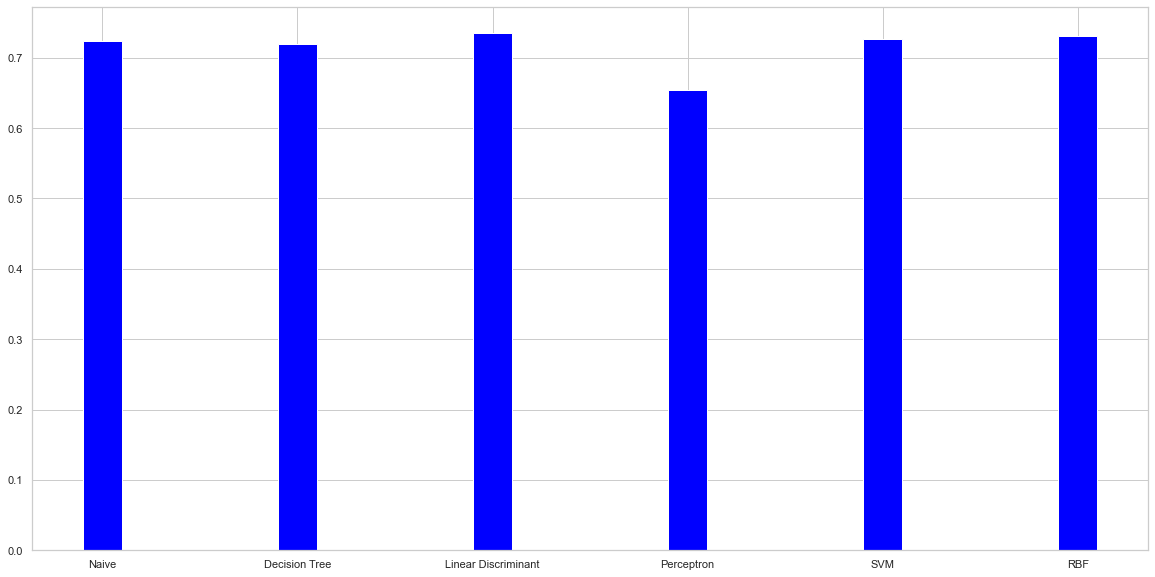

In [219]:
plt.figure(figsize=(20,10))
ax = plt.bar(l_algorithm,l_accuracy,color='blue',width=-0.2)

This part was a huge trial and error to get a figure plot that shows all the models and their scores in the same figure.

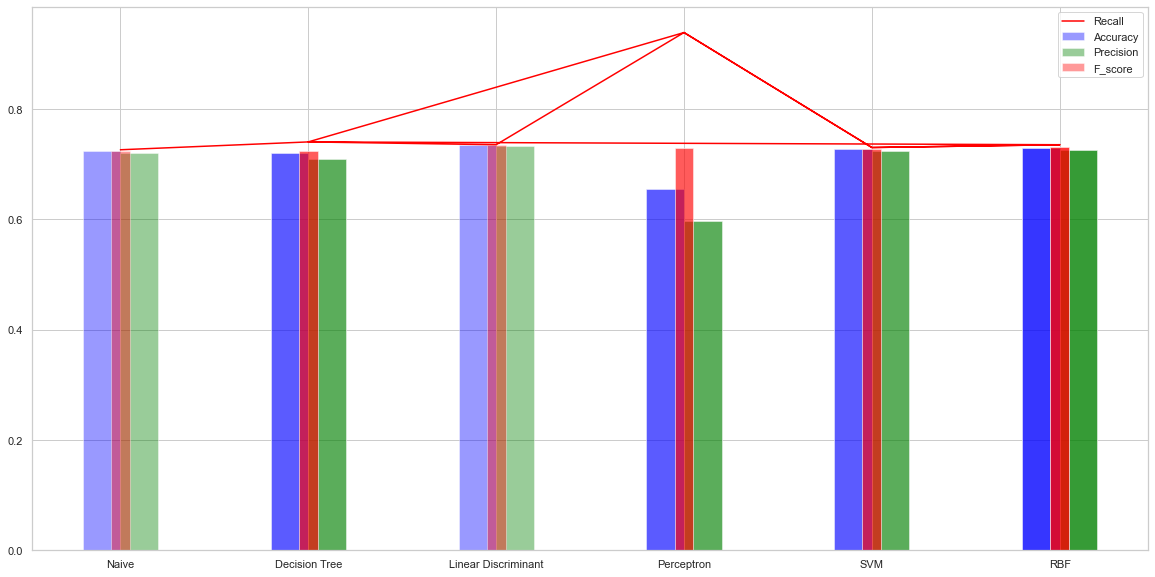

In [214]:
#[l_accuracy,l_f_score,l_precision,l_recall].hist(figsize=(12,10))
fig, ax = plt.subplots(sharex=False,sharey=False)

ax.bar(l_algorithm,height=l_accuracy,label='Accuracy',color='blue',width=-0.2,alpha=0.4,align='edge')
ax.bar(l_algorithm,height=l_precision,label='Precision',color='green',width=0.2,alpha=0.4,align='edge')
ax.bar(l_algorithm,height=l_f_score,label='F_score',color='red',width=0.1,alpha=0.4,align='center')
ax.plot(l_algorithm,l_recall,label='Recall',color='red')
#ax.violinplot(l_algorithm,l_precision)
#ax.hist(l_f_score, 10, None, ec='green', fc='none', lw=1.5, histtype='step', label='f_score')
ax.legend()
plt.ion()
fig.set_size_inches(20,10)

plt.show()

# Conclusion

LDA seems to be the best model at predicting wins in this scenario, and even though 73% doesn't seem like a big percentage, in this scenario that's a very high accuracy because even as a human it's very hard to predict the winning team provided the data in the dataset by the 10 minutes mark as stated before because games can take unusual turn and will stay for more than 30 minutes usually.

However this model won't predict correctly the games of other levels of games, as the accuracy drops to 52% in lower elo games as these games will be much more chaotic and data independent for the most part.

I tried the Model outside of the project and it detected correctly about 80% of the games played provided the data from the API at the 10 mins, and when constantly provieded with more data after the 10 minutes mark the accuracy keeps going up linearly up to 95% (in a pool of 20 played games).